In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as np
import jax.nn
from jax import jit, jacobian, vmap, lax
from jax.experimental import ode

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as onp
import scipy.integrate


0.01
(101, 50, 2)


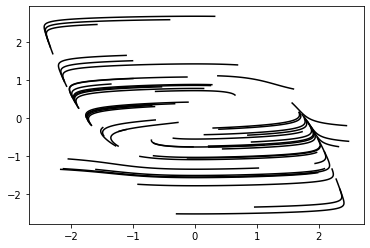

In [2]:
# simulate some data using ground truth vector field
def truevanderpol(x, t):
    mu = 3.0
    xdot = mu*(x[:,0] - x[:,0]**3/3 - x[:,1])
    ydot = x[:,0]/mu
    out = np.stack([xdot, ydot], axis=1)
    return out

ft = 1.0
npts = 101
dt = ft/(npts-1)
print(dt)
tint = np.arange(npts)*dt
truex0 = np.array(onp.random.normal(size=100).reshape((50,2)))
yjax = ode.odeint(truevanderpol, truex0, tint, rtol=1e-9, atol=1e-9)
yjax = np.squeeze(yjax)
print(yjax.shape)
for i in range(truex0.shape[0]):
    plt.plot(yjax[:,i,0], yjax[:,i,1], color='black')

plt.show()

In [3]:
# dimension of vector field
d = 2

# columns in ximat
xicols = 9

# the model, which consists of a linear combination of polynomial terms
def odeRHS(xIN, t, theta):
    x = np.squeeze(xIN)
    xy = np.array([x[0]*x[1], x[0]*x[1]**2, x[0]**2*x[1]])
    ximat = np.concatenate([x, x**2, x**3, xy],axis=0)
    beta = theta.reshape((xicols, d))
    out = ximat @ beta
    return out

# total number of parameters
numparams = xicols * d

# initialize parameter vector
theta0 = np.array(1e-6*onp.random.normal(size=numparams))

# check that we can integrate forward in time using one of the initial conditions
testtraj = ode.odeint(odeRHS, truex0[0], tint, theta0, rtol=1e-9, atol=1e-9)
print(testtraj.shape)

(101, 2)


In [4]:
# for reference, we include the parameter matrix theta that corresponds to the actual van der Pol vector field with mu = 3
truetheta = onp.zeros((9,2))
truetheta[0,:] = 1.0
truetheta[1,0] = -1.0
truetheta[4,0] = -1.0/3.0
truetheta[:,0] *= 3.0
truetheta[:,1] /= 3.0
print(truetheta)

[[ 3.          0.33333333]
 [-3.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [-1.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]]


In [6]:
# just-in-time (JIT) compiled version
jodeRHS = jit(odeRHS)

# use automatic differentiation and JIT together
gradodeRHS = jacobian(odeRHS, 0)
jgradodeRHS = jit(gradodeRHS)

# set up adjoint ODE
def adjRHS(lamb, x, t, theta):
    return -np.matmul(lamb, gradodeRHS(x, t, theta))

jadjRHS = jit(adjRHS)

# use automatic differentiation and JIT together
DthetaodeRHS = jacobian(odeRHS, 2)
jDthetaodeRHS = jit(DthetaodeRHS)

# vmap this one
jvDthetaodeRHS = jit(vmap(DthetaodeRHS, in_axes=(0, 0, None)))

In [7]:
# just the cost function
def cost(x0, curtheta, y):
    # internal time step
    dilfac = 1
    intdt = dt/dilfac
    
    # time interval for integration, also time interval of training data
    intnpts = (npts-1)*dilfac + 1
    inttint = np.arange(intnpts)*intdt
    xfine = ode.odeint(odeRHS, x0, inttint, curtheta, rtol=1e-9, atol=1e-9)
    xfine = np.squeeze(xfine)
    
    # extract the x's that correspond to the same times as y
    x = xfine[::dilfac, :]
    return 0.5*np.sum(np.square(y-x))

jcost = jit(cost)
jvcost = jit(vmap(cost, in_axes=(0, None, 1)))

In [11]:
# this commented code can be used to compare the adjoint method (coded below) with automatic differentiation through the JAX ODE solver

# the comparison can serve at least two purposes:
# 1) debugging errors in the adjoint method implementation, as the two methods should give very similar gradients
# 2) checking which method is faster or more scalable

# from jax import grad
# import time
# gradcost = grad(cost, 1)
# jgradcost = jit(gradcost)
# jgradcostx0 = jit(grad(cost, 0))
# start = time.time()
# jaxres1 = jgradcost(truex0, theta0)
# jaxres2 = jgradcostx0(truex0, theta0)
# end = time.time()
# print(end-start)

In [12]:
def newlagwithgrad(x0IN, curthetaIN, y):
    
    x0 = lax.stop_gradient(x0IN)
    curtheta = lax.stop_gradient(curthetaIN)
    
    # solves the forward ODE on a fine grid using our current estimates of xinit and curtheta
    # internal time step
    dilfac = 2
    intdt = dt/dilfac
    
    # time interval for integration, also time interval of training data
    intnpts = (npts-1)*dilfac + 1
    inttint = np.arange(intnpts)*intdt
    xfine = lax.stop_gradient(ode.odeint(odeRHS, x0, 
                                         inttint, 
                                         curtheta, rtol=1e-9, atol=1e-9))
    xfine = np.squeeze(xfine)
    
    # extract the x's that correspond to the same times as y
    x = xfine[::dilfac,:]
    yminusx = y - x
    
    # compute and save cost function
    obj = 0.5*np.sum(np.square(yminusx))
    
    # Heun's method backward in time
    inth = -intdt
    
    # Durand's rule quadrature weights
    w = onp.ones(intnpts)
    w[0] = 0.4
    w[1] = 11.0/10.0
    w[-2] = 11.0/10.0
    w[-1] = 0.4
    w = np.array(w) 
    
    # backward-in-time loop body
    def bodylamb(j, lambmfine):
        feval1 = adjRHS(lambmfine[intnpts-j, :], xfine[intnpts-j, :], inttint[intnpts-j], curtheta)
        lambtilde = lambmfine[intnpts-j, :] + inth*feval1
        feval2 = adjRHS(lambtilde, xfine[intnpts-j-1, :], inttint[intnpts-j-1], curtheta)
        prevlamb = lambmfine[intnpts-j, :] + (inth/2.0)*(feval1 + feval2)
        prevlamb += ((intnpts-j-1) % dilfac == 0) * yminusx[(intnpts-j-1)//dilfac, :]
        return lambmfine.at[intnpts-j-1].set( prevlamb )
    
    # loop initialization
    lambmat = np.vstack([ np.zeros((intnpts-1, d)), yminusx[[npts-1], :] ])
    
    # actually loop
    lambout = lax.fori_loop(1, intnpts, bodylamb, lambmat)
    
    # straight out of the notes
    dLdx0 = -lambout[0, :]
    gradtheta = 0
    allg = jvDthetaodeRHS(xfine, inttint, curtheta)
    gradtheta = -intdt*np.einsum('ijk,ij,i->k',allg, lambout, w)
    
    return obj, gradtheta, x, dLdx0

jnlwg = jit(newlagwithgrad)

In [13]:
start = time.time()
newobj, newgrad, newtraj, newdx0 = jnlwg(truex0[0], theta0, yjax[:,0,:])
end = time.time()
print(end-start)

2.3506574630737305


In [15]:
# using vmap, we can extend our function to compute gradients across multiple trajectories
jvnlwg = jit(vmap(newlagwithgrad, in_axes=(0, None, 1)))

# the function jvnlwg takes as input:
# -- numtraj x d array of initial conditions truex0
# -- 
newobj, newgrad, newtraj, newdx0 = jvnlwg(truex0, theta0, yjax)

In [16]:
xtheta = -onp.random.normal(size=numparams)**2
xtheta *= onp.exp(-np.arange(numparams))
xtheta = np.array(xtheta)
print(xtheta)
lr = 1e-2
maxiters = 1000

for i in range(maxiters):
    thiscost, thisgradtheta, _, _ = jvnlwg(truex0, xtheta, yjax)
    thiscost = np.mean(thiscost, axis=0)
    thisgrad = np.mean(thisgradtheta, axis=0)
    if i % 10 == 0:
        print(i, thiscost, np.linalg.norm(thisgrad))
    done = False
    thislr = lr
    while done==False:
        xthetatry = xtheta - thislr*thisgrad
        trycost = np.mean(jvcost(truex0, xthetatry, yjax), axis=0)
        if trycost < thiscost:
            xtheta = xthetatry
            lr = thislr
            done = True
        else:
            print(thislr, trycost)
            thislr /= 2
    

[-3.08441020e-03 -4.15397929e-02 -3.25639744e-01 -1.23889953e-02
 -5.03558016e-03 -6.03433850e-03 -5.26634099e-03 -4.80330833e-04
 -8.30046565e-05 -1.09168072e-04 -2.95446347e-06 -1.70919328e-06
 -7.50372757e-06 -7.35590271e-08 -3.18654684e-06 -2.58489501e-07
 -2.10779619e-08 -1.09705881e-07]
0 71.4208221682178 217.9195835832214
0.01 nan
0.005 63.84506814889101
0.0025 34.30882632753976
10 25.04148339882858 25.404142466765673
20 22.767275149722693 23.0075381324094
30 20.92576807457549 17.39355614860619
40 19.426674952052736 13.457912210398167
50 18.149627826253113 11.323839794140753
60 16.99663120830515 10.46670666392003
70 15.908540422658426 10.529876967078104
80 14.866367170818537 12.876212612945748
90 13.943891104720437 25.77628418046623
0.00125 13.956844916291393
100 13.298240516333658 9.073567838550169
110 12.791826658651756 9.025673945560197
120 12.291299366610733 8.970292689305596
130 11.797501837895524 8.906039245171712
140 11.311369375307818 8.832424012012902
150 10.83384338399

In [22]:
print(xtheta)
lr = 1e-2
maxiters = 1000

for i in range(maxiters):
    thiscost, thisgradtheta, _, _ = jvnlwg(truex0, xtheta, yjax)
    thiscost = np.mean(thiscost, axis=0)
    thisgrad = np.mean(thisgradtheta, axis=0)
    if i % 10 == 0:
        print(i, thiscost, np.linalg.norm(thisgrad))
    done = False
    thislr = lr
    while done==False:
        xthetatry = xtheta - thislr*thisgrad
        trycost = np.mean(jvcost(truex0, xthetatry, yjax), axis=0)
        if trycost < thiscost:
            xtheta = xthetatry
            lr = thislr
            done = True
        else:
            print(thislr, trycost)
            thislr /= 2


[ 2.27840515  0.35140422 -2.25078896  0.22688532 -0.03073032 -0.02476082
 -0.06791773 -0.02905127 -0.66383744  0.01485412 -0.41330567 -0.08449745
 -0.09800133 -0.05835734 -0.319814   -0.14619149  0.1311703  -0.08084827]
0 0.9343225377430477 1.6244648276891596
0.01 0.9027923117724177
0.005 0.8631257023074501
0.0025 0.9176676875445676
0.00125 0.8602195094841771
10 0.844359603633712 1.5306634019109293
20 0.8299870667276389 1.515330017702976
30 0.8158991942880042 1.5002573131019061
40 0.8020892349784029 1.485391997079739
50 0.788550676473003 1.470729616599664
60 0.7752771947553481 1.4562659243003313
70 0.7622626480828174 1.4419968416508444
80 0.7495010701702048 1.427918444166763
90 0.7369866633514477 1.4140269512109098
100 0.7247137924146588 1.400318718389197
110 0.7126769782335824 1.386790228560769
120 0.7008708917676839 1.3734380848257526
130 0.6892903492613153 1.3602590039540872
140 0.6779303069703894 1.3472498111691367
150 0.6667858554668041 1.334407431597593
160 0.6558522161363135 1.3

In [17]:
def siobj(x):
    jx = lax.stop_gradient( np.array(x) ) #, device=jax.devices()[0]) )
    return onp.mean( jvcost( truex0, jx, yjax ), axis=0 )

def sigrad(x):
    jx = lax.stop_gradient( np.array(x) ) #, device=jax.devices()[0]) )
    _, gradtheta, _, _ = jvnlwg( truex0, jx, yjax ) 
    return onp.mean( onp.array( gradtheta ), axis=0 )

In [18]:
import scipy.optimize as so

In [23]:
res = so.minimize(siobj,
                  jac=sigrad,
                  x0=np.array(xtheta), 
                  method='l-bfgs-b', # , hess=so.SR1(), options = {'verbose': 3} ) 
                  options = {'iprint': 1, 'ftol': 1e-12, 'gtol': 1e-12,
                              'maxfun': 150000, 'maxiter': 150000, 'maxcor': 10, 'maxls': 20} )


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.83389D-01    |proj g|=  3.78052D-01


 This problem is unconstrained.



At iterate    1    f=  1.62357D-02    |proj g|=  8.02878D-01

At iterate    2    f=  1.51836D-02    |proj g|=  1.01093D+00

At iterate    3    f=  1.36563D-02    |proj g|=  6.34120D-01

At iterate    4    f=  1.17580D-02    |proj g|=  5.50976D-01

At iterate    5    f=  1.04011D-02    |proj g|=  4.31599D-01

At iterate    6    f=  7.43090D-03    |proj g|=  2.92038D-01

At iterate    7    f=  6.22746D-03    |proj g|=  5.09805D-01

At iterate    8    f=  4.85310D-03    |proj g|=  2.07748D-01

At iterate    9    f=  4.32177D-03    |proj g|=  1.80040D-01

At iterate   10    f=  3.19923D-03    |proj g|=  2.69683D-01

At iterate   11    f=  1.95309D-03    |proj g|=  3.18239D-01

At iterate   12    f=  7.31474D-04    |proj g|=  1.92803D-01

At iterate   13    f=  6.22249D-04    |proj g|=  2.41001D-01

At iterate   14    f=  4.48830D-04    |proj g|=  1.08897D-01

At iterate   15    f=  3.96334D-04    |proj g|=  9.96033D-02

At iterate   16    f=  2.91230D-04    |proj g|=  2.00142D-01

At iter

In [24]:
print(res.x)

[ 3.00000069e+00  3.33333093e-01 -3.00000035e+00  9.06099315e-08
 -2.02685592e-08 -9.30654714e-08  3.14020362e-09  7.15138200e-08
 -1.00000027e+00  3.46566730e-08  1.69531374e-07  6.99891911e-08
 -3.74926923e-07 -5.85394649e-08 -1.97510550e-07 -2.53548198e-08
 -4.70493521e-07 -1.61611487e-07]


In [27]:
np.mean(np.square(res.x.reshape((xicols,d)) - truetheta))

DeviceArray(6.76605006e-14, dtype=float64)